# Libraries

In [ ]:
import os
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt  # <-- for plotting

from collections import deque
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/UT/Credit-Bias Project/Revision/Codes

# ----------------------
# Check Device
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Mounted at /content/drive
/content/drive/MyDrive/UT/Credit-Bias Project/Revision/Codes
Using device: cuda


#Arm Races

## Bad player

In [ ]:
# ----------------------
# 1) Modified Environment (same as before)
# ----------------------
class OpinionEnv9Actions:
    """
    Environment that uses 9 discrete actions for each "player" (row & column).
    Here, we will treat the 'player' action as the one we learn while the
    'opponent' action will be fixed.
    """
    def __init__(self,
                 num_envs=32,
                 N=500,
                 M=10,
                 terminal_time=200,
                 bM=5,
                 b=20,
                 noise_level=0.1,
                 h=0.1,
                 nbins=30,
                 r_scale=100,
                 eta=1,
                 eta2=2,
                 beta_1=3,
                 beta_2=2,
                 lambda_c=0.98):
        self.num_envs = num_envs
        self.N = N
        self.M = M
        self.terminal_time = terminal_time
        self.bM = bM
        self.b = b
        self.noise_level = noise_level
        self.h = torch.tensor(h, device=device, dtype=torch.float32)
        self.nbins = nbins
        self.r_scale = r_scale
        self.eta = eta
        self.eta2 = eta2
        self.lambda_c = lambda_c
        self.pi = torch.tensor(math.pi, device=device)

        # Beta distribution for s
        self.BetaDist = torch.distributions.beta.Beta(beta_1, beta_2)

        # Media positions in [-1,1]
        self.ym = torch.linspace(-1, 1, steps=self.M, device=device)

        # Environment states: x, c, t, s
        self.x = torch.zeros(self.num_envs, self.N, device=device)
        self.c = torch.zeros(self.num_envs, self.M, device=device)
        self.t = torch.zeros(self.num_envs, device=device)
        self.s = self.BetaDist.sample(sample_shape=(self.num_envs, self.N)).to(device)
        self.AEm = torch.zeros((self.num_envs, self.N, self.M), device=device)

        # Exactly 9 actions
        self.action_dim = 9

        # Probabilities and deltas for the 9 discrete actions
        self.probabilities = torch.tensor(
            [0.95, 0.95, 0.95, 0.50, 0.50, 0.10, 0.10, 0.50, 0.10],
            device=device
        )
        self.deltas = torch.tensor(
            [0.000001, 0.85, 0.45, -0.00001, -0.45, -0.85, -0.0000001, 0.4, -0.4],
            device=device
        )
        # For the M/2 dimension: used to create Bernoulli vectors from discrete actions
        self.zm = torch.linspace(0, 1, steps=self.M // 2, device=device)

        self.reset()

    def reset(self):
        with torch.no_grad():
            self.x.uniform_(-1.0, 1.0)
            self.c.fill_(1.0)
            self.t.zero_()

            self.s = self.BetaDist.sample(sample_shape=(self.num_envs, self.N)).to(device)
            self.AEm.fill_(0.0)
        return self.state2obs()

    def state2obs(self):
        """
        Observation shape: [num_envs, nbins + M] = [hist(x), c].
        """
        obs_list = []
        for i in range(self.num_envs):
            hist_i = torch.histc(self.x[i], bins=self.nbins, min=-1, max=1)
            hist_i = hist_i / self.N
            obs_list.append(torch.cat([hist_i, self.c[i]]))
        obs = torch.stack(obs_list, dim=0)
        return obs

    def _convert_action_ids_to_vec(self, action_ids):
        """
        Convert each action_id in {0..8} to an M/2 Bernoulli vector.
        """
        base_probs = self.probabilities[action_ids]  # [num_envs]
        delta_probs = self.deltas[action_ids]        # [num_envs]
        final_prob = base_probs.unsqueeze(1) - self.zm.unsqueeze(0) * delta_probs.unsqueeze(1)
        final_prob = final_prob.clamp(min=0.0, max=1.0)
        action_vec = torch.bernoulli(final_prob)
        return action_vec  # shape: [num_envs, M//2]

    def step(self, action_pl_ids, action_op_ids):
        """
        Step the environment by one Euler iteration.
        action_pl_ids: player’s discrete actions (shape [num_envs])
        action_op_ids: opponent’s discrete actions (shape [num_envs]) – fixed.
        """
        with torch.no_grad():
            # Build row & column actions
            row_act = self._convert_action_ids_to_vec(action_pl_ids)
            col_act = self._convert_action_ids_to_vec(action_op_ids)
            action = torch.cat([row_act, col_act], dim=1)

            DM = self.ym.view(1, 1, -1) - self.x.unsqueeze(2)  # [num_envs, N, M]
            xx = self.x.unsqueeze(2)
            D = xx - xx.transpose(1, 2)                        # [num_envs, N, N]

            # Media adjacency factor
            fac = (1.0 + self.eta * action).unsqueeze(1) * (
                1.0 + self.eta2 * (2.0 - self.c - action).unsqueeze(1) * (1.0 - self.s).unsqueeze(2)
            )
            AM = torch.exp(-self.bM * fac * torch.abs(DM))     # [num_envs, N, M]
            A = torch.exp(-self.b * torch.abs(D))              # [num_envs, N, N]
            self.media_attention = AM

            self.AEm += torch.exp(-self.bM * torch.abs(DM)) * (1 - action.unsqueeze(1))
            # Credibility update
            self.c = self.c * self.lambda_c + action * (1 - self.lambda_c)

            # Compute social and media updates
            x_update_social = -(A * D).sum(dim=2) / A.sum(dim=2).clamp_min(1e-12)
            x_update_media = (AM * DM).sum(dim=2) / AM.sum(dim=2).clamp_min(1e-12)

            noise = torch.normal(mean=0.0, std=self.noise_level, size=(self.num_envs, self.N), device=device)
            self.x = self.x + self.h * (x_update_social + x_update_media) + torch.sqrt(self.h) * noise

            self.t += 1

            sin_val = torch.sin((self.pi / 2.0) * self.x)
            sin_pow5 = sin_val.pow(5)
            mean_sin_pow5 = sin_pow5.mean(dim=1)
            rewards = self.r_scale * (-mean_sin_pow5)
            done = (self.t >= self.terminal_time)
            if done.any():
              rewards=100*rewards

        next_obs = self.state2obs()
        return next_obs, rewards, done, {}


# ----------------------
# 2) GPU-based Replay Buffer (unchanged except that we now only really need the player's action)
# ----------------------
class GPUReplayBuffer:
    def __init__(self, capacity, obs_dim):
        self.capacity = capacity
        self.obs_dim = obs_dim
        self.index = 0
        self.size = 0

        self.obs_buf      = torch.zeros((capacity, obs_dim), device=device)
        self.next_obs_buf = torch.zeros((capacity, obs_dim), device=device)
        self.actions_pl   = torch.zeros((capacity,), dtype=torch.long, device=device)
        # Although we no longer need the opponent’s action (it is fixed), we store it for compatibility.
        self.actions_op   = torch.zeros((capacity,), dtype=torch.long, device=device)
        self.rewards      = torch.zeros((capacity,), device=device)
        self.dones        = torch.zeros((capacity,), device=device)

    def store(self, obs, action_pl, action_op, reward, next_obs, done):
        batch_size = obs.shape[0]
        end_idx = self.index + batch_size

        if end_idx <= self.capacity:
            idx_range = torch.arange(self.index, end_idx, device=device)
        else:
            remainder = end_idx - self.capacity
            idx_range1 = torch.arange(self.index, self.capacity, device=device)
            idx_range2 = torch.arange(0, remainder, device=device)
            idx_range = torch.cat([idx_range1, idx_range2], dim=0)

        self.obs_buf[idx_range]      = obs
        self.actions_pl[idx_range]   = action_pl
        self.actions_op[idx_range]   = action_op
        self.rewards[idx_range]      = reward
        self.next_obs_buf[idx_range] = next_obs
        self.dones[idx_range]        = done

        self.index = (self.index + batch_size) % self.capacity
        self.size  = min(self.size + batch_size, self.capacity)

    def sample(self, batch_size):
        idxs = np.random.randint(0, self.size, size=batch_size)
        idxs_t = torch.from_numpy(idxs).to(device)

        obs       = self.obs_buf[idxs_t]
        a_pl      = self.actions_pl[idxs_t]
        a_op      = self.actions_op[idxs_t]  # (will be fixed)
        rewards   = self.rewards[idxs_t]
        next_obs  = self.next_obs_buf[idxs_t]
        dones     = self.dones[idxs_t]
        return obs, a_pl, a_op, rewards, next_obs, dones


# ----------------------
# 3) Single-Agent Q–Network
# ----------------------
class QNet(nn.Module):
    """
    A simple Q–network that outputs Q(s,a) for the player's 9 actions.
    """
    def __init__(self, observation_dim, action_dim=9):
        super(QNet, self).__init__()
        self.observation_dim = observation_dim
        self.action_dim = action_dim

        hidden1 = 64
        hidden2 = 64
        hidden3 = 64

        self.fc1 = nn.Linear(self.observation_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.out = nn.Linear(hidden3, self.action_dim)

    def forward(self, obs):
        x = F.relu(self.fc1(obs))
        x = F.relu(self.fc2(x))
        # x = (self.fc3(x))
        q = self.out(x)  # Shape: [batch, action_dim]
        return q

    def batch_act(self, obs, epsilon=0.1, beta=10.0):
        """
        Epsilon–greedy action selection.
        With probability epsilon, choose a random action.
        Otherwise, sample from a softmax distribution computed from Q–values.
        """
        with torch.no_grad():
            q_values = self.forward(obs)  # [batch, action_dim]
            # Compute softmax probabilities (using beta as an inverse temperature)
            pi = F.softmax(beta * q_values, dim=-1)
            batch_size = obs.shape[0]
            actions = torch.empty(batch_size, dtype=torch.long, device=device)
            # Epsilon–greedy: decide for each sample whether to choose random action
            rand_vals = torch.rand(batch_size, device=device)
            random_mask = rand_vals < epsilon
            num_random = random_mask.sum().item()
            if num_random > 0:
                actions[random_mask] = torch.randint(0, self.action_dim, (num_random,), device=device)
            # For non–random selections, sample from the softmax distribution
            if (~random_mask).sum().item() > 0:
                dist = torch.distributions.Categorical(pi[~random_mask])
                actions[~random_mask] = dist.sample()
        return actions


# ----------------------
# 4) Soft Q–Update for Single Agent
# ----------------------
def soft_q_update_single(replay_buffer, target_net, eval_net, gamma, optimizer, batch_size, tau=0.01, beta=10.0):
    """
    One gradient update for the single agent.
    """
    obs, a_pl, a_op, rewards, next_obs, dones = replay_buffer.sample(batch_size)
    # Compute current Q(s,a) for the player's action only.
    q_values = eval_net(obs)  # [batch, action_dim]
    q_sa = q_values.gather(1, a_pl.unsqueeze(1)).squeeze(1)

    # Compute V(s') using soft–max (log–sum–exp)
    with torch.no_grad():
        q_values_next = target_net(next_obs)  # [batch, action_dim]
        max_q, _ = q_values_next.max(dim=1, keepdim=True)
        # Correct numerically stable softmax value:
        V_next = max_q.squeeze(1) + (1.0 / beta) * torch.log(torch.sum(torch.exp(beta * (q_values_next - max_q)), dim=1))
        target = rewards + gamma * (1.0 - dones) * V_next

    # with torch.no_grad():
    #     q_values_next = target_net(next_obs)  # [batch, action_dim]
    #     # Numerically stable log–sum–exp:
    #     max_q, _ = q_values_next.max(dim=1, keepdim=True)
    #     V_next = (1.0 / beta) * (torch.log(torch.sum(torch.exp(beta * (q_values_next - max_q)), dim=1)) + max_q.squeeze(1))
    #     target = rewards + gamma * (1.0 - dones) * V_next

    loss = F.mse_loss(q_sa, target)
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(eval_net.parameters(), 1.0)
    optimizer.step()

    # Soft update of target network parameters
    with torch.no_grad():
        for tp, ep in zip(target_net.parameters(), eval_net.parameters()):
            tp.data.copy_(tau * ep.data + (1 - tau) * tp.data)

    return loss.item()


def training_plot(env, rewards_history, step_count, train_count):
    with torch.no_grad():
        avg_rew_recent = np.mean(rewards_history[-100:]) if len(rewards_history) > 100 else np.mean(rewards_history)
        print(f"Step: {step_count}, Train count: {train_count}, AvgReward(last100): {avg_rew_recent:.4f}")

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        axes[0].plot(rewards_history, label="Avg Reward per Step")
        axes[0].set_title(f"Average Reward up to Step {step_count}")
        axes[0].set_xlabel("Env Step")
        axes[0].set_ylabel("Average Reward")
        axes[0].legend()

        avg_credibility = env.c.detach().cpu().numpy().mean(axis=0)
        M = avg_credibility.shape[0]
        axes[1].scatter(np.linspace(-1, 1, M), avg_credibility, s=100, alpha=0.7)
        axes[1].set_xlabel("Media Position")
        axes[1].set_ylabel("Avg Credibility")
        axes[1].set_title("Credibility vs. Media Position")

        plt.tight_layout()
        plt.show()
        plt.close()


# ----------------------
# 5) Main Training Loop for Single Agent
# ----------------------

# Hyperparameters
num_envs = 100
N = 500
M = 10
gamma = 0.9
learning_rate = 1e-4
max_train_steps = 20000    # total training updates
train_start = 2000         # minimum replay buffer size before training
train_freq = 10            # train every N environment steps
batch_size = 128
terminal_time =200
capacity = 500 * num_envs * terminal_time
tau = 0.01
epsilon = 0.1
beta = 10             # inverse temperature for softmax action selection
obs_dim = 30 + M         # (nbins=30 + M=10 => 40)
action_dim = 9           # 9 discrete actions
fixed_opponent_action = 6  # The opponent always plays action 6

# Create directories for saving models/plots
os.makedirs("models_single_agent", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# Create environment
env = OpinionEnv9Actions(
    num_envs=num_envs,
    N=N,
    M=M,
    terminal_time=terminal_time,
    bM=5,
    b=20,
    noise_level=0.1,
    h=0.1,
    nbins=30,
    r_scale=100,
    eta=1,
    eta2=1,
    beta_1=3,
    beta_2=2,
    lambda_c=0.98
)

# Create replay buffer on GPU
buffer = GPUReplayBuffer(capacity, obs_dim=obs_dim)

# Create networks
eval_net = QNet(observation_dim=obs_dim, action_dim=action_dim).to(device)
target_net = QNet(observation_dim=obs_dim, action_dim=action_dim).to(device)
target_net.load_state_dict(eval_net.state_dict())

optimizer = torch.optim.Adam(eval_net.parameters(), lr=learning_rate, weight_decay=1e-4)

# Initial environment reset
obs = env.reset()

step_count = 0    # counts environment steps
train_count = 0   # counts training updates
rewards_history = []
loss_history = []
done_count=0

over_all_rewards=0
while train_count < max_train_steps:
    # The learning agent selects an action (for the 'player')
    a_pl = eval_net.batch_act(obs, epsilon=epsilon, beta=beta)
    # The opponent always plays the fixed action.
    a_op = fixed_opponent_action * torch.ones(env.num_envs, device=device, dtype=torch.long)

    # Step the environment
    next_obs, rewards, done, _ = env.step(a_pl, a_op)
    step_count += 1
    over_all_rewards+=rewards.mean().item()
    # Store transition in the replay buffer
    buffer.store(obs, a_pl, a_op, rewards, next_obs, done.float())

    obs = next_obs.clone()

    # Train only if enough samples have been collected
    if buffer.size > train_start:
        if step_count % train_freq == 0:
            # print("trained")
            train_count += 1
            loss_val = soft_q_update_single(buffer, target_net, eval_net, gamma, optimizer, batch_size, tau, beta)
            loss_history.append(loss_val)

    # Reset environments that are done
    mask_done = (done == True)
    if mask_done.any():
        # print("Reset")
        done_count+=1
        rewards_history.append(over_all_rewards/env.terminal_time)
        over_all_rewards=0
        if train_count > 0:
            # print("plot")
            if done_count%10==0:
                checkpoint_path = "models_single_agent/checkpoint_net.pth"
                torch.save(eval_net.state_dict(), checkpoint_path)
                training_plot(env, rewards_history, step_count, train_count)
                # rewards_history=[]
                print(f"Saved checkpoint: {checkpoint_path}")
        new_obs = env.reset()
        obs[mask_done] = new_obs[mask_done]

# Save final model
final_path = "models_single_agent/final_eval_net.pth"
torch.save(eval_net.state_dict(), final_path)
print(f"Training done. Final model saved at {final_path}")


Output hidden; open in https://colab.research.google.com to view.

Using device: cuda


<ipython-input-7-ac7a08a1a1c2>:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_net.load_state_dict(torch.load(model_path, map_location=device))


Done
Average reward: 1.4996456309524364


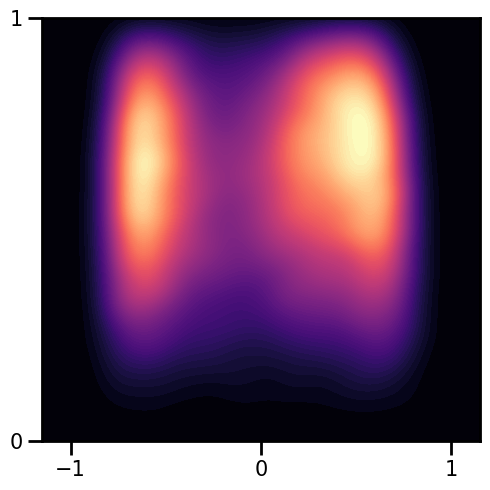

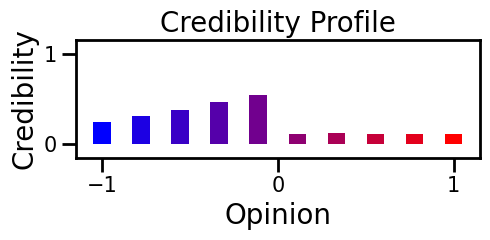

<ipython-input-7-ac7a08a1a1c2>:165: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(env.ym.cpu(),avg_credibility,'-o',linewidth=3,marker=".", markersize=50,alpha=1)


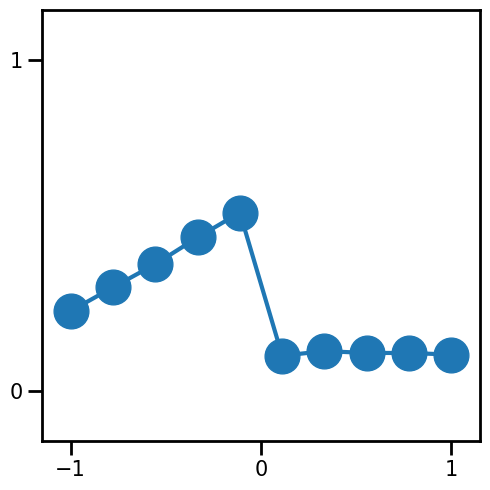

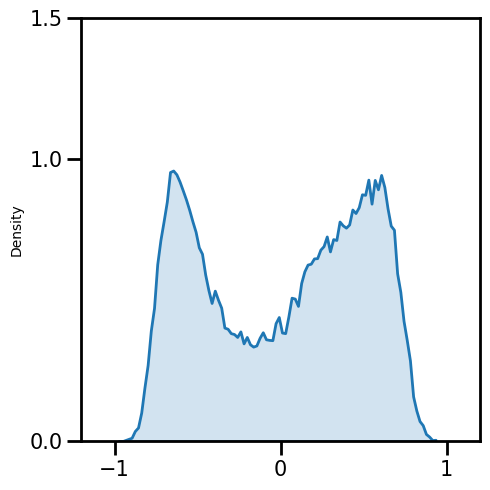

<ipython-input-7-ac7a08a1a1c2>:206: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y=env.AEm.sum(axis=2).cpu().flatten()[x>0].mean()/env.terminal_time


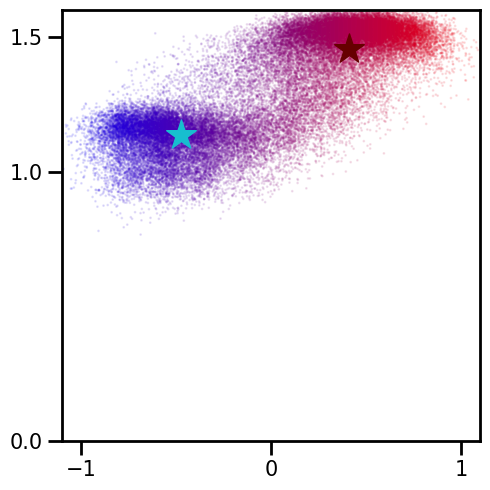

In [ ]:
import os
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import scipy.stats as stats


# ----------------------
# Check Device
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# Hyperparameters
num_envs = 100
N = 500
M = 10
gamma = 0.9
learning_rate = 1e-3
max_train_steps = 20000    # total training updates
train_start = 2000         # minimum replay buffer size before training
train_freq = 10            # train every N environment steps
batch_size = 128
terminal_time =200
capacity = 500 * num_envs * terminal_time
tau = 0.005
epsilon = 0.2
beta = 10              # inverse temperature for softmax action selection
obs_dim = 30 + M         # (nbins=30 + M=10 => 40)
action_dim = 9           # 9 discrete actions
fixed_opponent_action = 6  # The opponent always plays action 6
op_type="bad_player"

# Create directories
os.makedirs(op_type, exist_ok=True)

# Create environment
env = OpinionEnv9Actions(
    num_envs=num_envs,
    N=N,
    M=M,
    terminal_time=terminal_time,
    bM=5,
    b=20,
    noise_level=0.1,
    h=0.1,
    nbins=30,
    r_scale=100,
    eta=1,
    eta2=1,
    beta_1=3,
    beta_2=2,
    lambda_c=0.98
)






test_net = QNet(observation_dim=obs_dim, action_dim=action_dim).to(device)
#########################################
#  1) LOAD the final trained model weights
#########################################
model_path = "models_single_agent/final_eval_net.pth"  # or use "checkpoint_epoch_1000.pth" etc.
# model_path = "models_single_agent/checkpoint_net.pth"
test_net.load_state_dict(torch.load(model_path, map_location=device))
test_net.eval()
# print(f"Loaded model from {model_path}")

#########################################
#  2) Run the testing (env.num_env episodes)
#########################################
obs = env.reset()
opinon_data=torch.zeros([env.num_envs,N,env.terminal_time],device=device)
overall_reward=0
with torch.no_grad():
    while True:
        # Choose actions for each env
        a_pl = eval_net.batch_act(obs, epsilon=epsilon, beta=beta)
        # The opponent always plays the fixed action.
        a_op = fixed_opponent_action * torch.ones(env.num_envs, device=device, dtype=torch.long)

        # Step the environment
        next_obs, rewards, done, _ = env.step(a_pl, a_op)
        overall_reward+=rewards.mean().item()
        obs = next_obs.clone()
        mask_done = (done == True)
        if mask_done[0]:
          print("Done")
          break
        opinon_data[:,:,env.t[0].to(torch.int)]=env.x

print(f"Average reward: {overall_reward/env.terminal_time}")

import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("custom_blue_red", [(0, 0, 1), (1, 0, 0)], N=100)
#########################################
#  3) Plotting opinon-susceptibility distributions
#########################################
# Plot final average credibility
avg_credibility =  env.c.detach().cpu().numpy() .mean(axis=0)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.kdeplot(x=opinon_data.detach().mean(axis=2).reshape(-1).cpu().numpy(), y=env.s.detach().reshape(-1).cpu().numpy(), fill=True, thresh=None, cmap="magma", levels=100, ax=ax)
ax.set_xlim(-1.15, 1.15)
ax.set_ylim(0, 1)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
plt.tight_layout()
plt.savefig(f'{op_type}/xs200-b10.svg')
plt.show()
# Create the custom blue-red colormap




# Assume that env.ym and env.c[0] are available from your environment
# Convert tensor data to numpy arrays (or adjust if they are already numpy arrays)
opinions = env.ym.cpu().numpy()            # x-values (Opinion)
credibility = env.c.cpu().numpy().mean(axis=0)         # y-values (Credibility)
norm = plt.Normalize(vmin=-1, vmax=1)
bar_colors = cmap(norm(opinions))

fig, ax = plt.subplots(figsize=(5, 2.5))
bar_width = 0.1

ax.bar(opinions, credibility, width=bar_width, color=bar_colors, align='center')

# Set the limits, ticks, and styling as before
ax.set_xlim([-1.15, 1.15])
ax.set_ylim([-0.15, 1.15])
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Set titles and labels
ax.set_title("Credibility Profile", fontsize=20)
ax.set_xlabel("Opinion", fontsize=20)
ax.set_ylabel("Credibility", fontsize=20)

# Adjust layout and save/show the figure
plt.tight_layout()
plt.savefig(f"{op_type}/cx_bar.svg", dpi=300)
plt.show()
plt.close()




fig,ax=plt.subplots(figsize=(5,5))
ax.plot(env.ym.cpu(),avg_credibility,'-o',linewidth=3,marker=".", markersize=50,alpha=1)
ax.set_xlim([-1.15 ,1.15])
ax.set_ylim([-0.15, 1.15])
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
plt.tight_layout()
plt.savefig(f'{op_type}/xc_bad_player.svg')
plt.show()

fig,ax=plt.subplots(figsize=(5,5))
sns.histplot(opinon_data.detach().mean(axis=2).reshape(-1).cpu().numpy(),
             bins=100, element="poly", stat="density",alpha=.2,linewidth=2)
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(0, 1.5)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0,1 ,1.5])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
# ax.set_xlabel('Opinion',fontsize=15)
# ax.set_ylabel('Credibility',fontsize=15)
plt.tight_layout()
plt.savefig(f"{op_type}/Dist.svg",dpi=300)
plt.show()



cmap = LinearSegmentedColormap.from_list("custom_blue_red",[(0, 0, 1), (1, 0, 0)], N=100)
fig,ax=plt.subplots(figsize=(5,5))
env_rand=np.random.randint(0,env.num_envs)
x=env.x.squeeze().cpu().numpy().flatten()
ax.scatter(y=env.AEm.sum(axis=2).cpu().flatten().numpy()/(env.terminal_time-1),x=x,c=x,cmap=cmap,s=1,alpha=.1)
ax.scatter(y=env.AEm.sum(axis=2).cpu().flatten()[x>0].mean()/env.terminal_time
           ,x=x[x>0].mean(),s=500,alpha=1,c=[.4,0,0],marker='*',linewidths=1)
ax.scatter(y=env.AEm.sum(axis=2).cpu().flatten()[x<0].mean()/env.terminal_time
           ,x=x[x<0].mean(),s=500,alpha=1,c='tab:cyan',marker='*',linewidths=1)
# ax.scatter(y=env.AEm[env_rand,:,:].sum(axis=1).cpu().flatten().numpy()/(env.terminal_time-1),x=x,c=x,cmap=cmap,s=10,alpha=1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(0, 1.6)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0,1 ,1.5])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
# ax.set_xlabel('Opinion',fontsize=15)
# ax.set_ylabel('Credibility',fontsize=15)
plt.tight_layout()
plt.savefig(f"{op_type}/Exposure.svg",dpi=300)
plt.show()
plt.close()




## Good Player

In [ ]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ----------------------
# 1) Modified Environment (same as before)
# ----------------------
class OpinionEnv9Actions:
    """
    Environment that uses 9 discrete actions for each "player" (row & column).
    Here, we will treat the 'player' action as the one we learn while the
    'opponent' action will be fixed.
    """
    def __init__(self,
                 num_envs=32,
                 N=500,
                 M=10,
                 terminal_time=200,
                 bM=5,
                 b=20,
                 noise_level=0.1,
                 h=0.1,
                 nbins=30,
                 r_scale=100,
                 eta=1,
                 eta2=2,
                 beta_1=3,
                 beta_2=2,
                 lambda_c=0.98):
        self.num_envs = num_envs
        self.N = N
        self.M = M
        self.terminal_time = terminal_time
        self.bM = bM
        self.b = b
        self.noise_level = noise_level
        self.h = torch.tensor(h, device=device, dtype=torch.float32)
        self.nbins = nbins
        self.r_scale = r_scale
        self.eta = eta
        self.eta2 = eta2
        self.lambda_c = lambda_c
        self.pi = torch.tensor(math.pi, device=device)

        # Beta distribution for s
        BetaDist = torch.distributions.beta.Beta(beta_1, beta_2)

        # Media positions in [-1,1]
        self.ym = torch.linspace(-1, 1, steps=self.M, device=device)

        # Environment states: x, c, t, s
        self.x = torch.zeros(self.num_envs, self.N, device=device)
        self.c = torch.zeros(self.num_envs, self.M, device=device)
        self.t = torch.zeros(self.num_envs, device=device)
        self.s = BetaDist.sample(sample_shape=(self.num_envs, self.N)).to(device)
        self.AEm = torch.zeros((self.num_envs, self.N, self.M), device=device)

        # Exactly 9 actions
        self.action_dim = 9

        # Probabilities and deltas for the 9 discrete actions
        self.probabilities = torch.tensor(
            [0.95, 0.95, 0.95, 0.50, 0.50, 0.10, 0.10, 0.50, 0.10],
            device=device
        )
        self.deltas = torch.tensor(
            [0.000001, 0.85, 0.45, -0.00001, -0.45, -0.85, -0.0000001, 0.4, -0.4],
            device=device
        )
        # For the M/2 dimension: used to create Bernoulli vectors from discrete actions
        self.zm = torch.linspace(0, 1, steps=self.M // 2, device=device)

        self.reset()

    def reset(self):
        with torch.no_grad():
            self.x.uniform_(-1.0, 1.0)
            self.c.fill_(1.0)
            self.t.zero_()
            BetaDist = torch.distributions.beta.Beta(3, 2)
            self.s = BetaDist.sample(sample_shape=(self.num_envs, self.N)).to(device)
            self.AEm.fill_(0.0)
        return self.state2obs()

    def state2obs(self):
        """
        Observation shape: [num_envs, nbins + M] = [hist(x), c].
        """
        obs_list = []
        for i in range(self.num_envs):
            hist_i = torch.histc(self.x[i], bins=self.nbins, min=-1, max=1)
            hist_i = hist_i / self.N
            obs_list.append(torch.cat([hist_i, self.c[i]]))
        obs = torch.stack(obs_list, dim=0)
        return obs

    def _convert_action_ids_to_vec(self, action_ids):
        """
        Convert each action_id in {0..8} to an M/2 Bernoulli vector.
        """
        base_probs = self.probabilities[action_ids]  # [num_envs]
        delta_probs = self.deltas[action_ids]        # [num_envs]
        final_prob = base_probs.unsqueeze(1) - self.zm.unsqueeze(0) * delta_probs.unsqueeze(1)
        final_prob = final_prob.clamp(min=0.0, max=1.0)
        action_vec = torch.bernoulli(final_prob)
        return action_vec  # shape: [num_envs, M//2]

    def step(self, action_pl_ids, action_op_ids):
        """
        Step the environment by one Euler iteration.
        action_pl_ids: player’s discrete actions (shape [num_envs])
        action_op_ids: opponent’s discrete actions (shape [num_envs]) – fixed.
        """
        with torch.no_grad():
            # Build row & column actions
            row_act = self._convert_action_ids_to_vec(action_pl_ids)
            col_act = self._convert_action_ids_to_vec(action_op_ids)
            action = torch.cat([row_act, col_act], dim=1)

            DM = self.ym.view(1, 1, -1) - self.x.unsqueeze(2)  # [num_envs, N, M]
            xx = self.x.unsqueeze(2)
            D = xx - xx.transpose(1, 2)                        # [num_envs, N, N]

            # Media adjacency factor
            fac = (1.0 + self.eta * action).unsqueeze(1) * (
                1.0 + self.eta2 * (2.0 - self.c - action).unsqueeze(1) * (1.0 - self.s).unsqueeze(2)
            )
            AM = torch.exp(-self.bM * fac * torch.abs(DM))     # [num_envs, N, M]
            A = torch.exp(-self.b * torch.abs(D))              # [num_envs, N, N]
            self.media_attention = AM

            self.AEm += torch.exp(-self.bM * torch.abs(DM)) * (1 - action.unsqueeze(1))
            # Credibility update
            self.c = self.c * self.lambda_c + action * (1 - self.lambda_c)

            # Compute social and media updates
            x_update_social = -(A * D).sum(dim=2) / A.sum(dim=2).clamp_min(1e-12)
            x_update_media = (AM * DM).sum(dim=2) / AM.sum(dim=2).clamp_min(1e-12)

            noise = torch.normal(mean=0.0, std=self.noise_level, size=(self.num_envs, self.N), device=device)
            self.x = self.x + self.h * (x_update_social + x_update_media) + torch.sqrt(self.h) * noise

            self.t += 1

            sin_val = torch.sin((self.pi / 2.0) * self.x)
            sin_pow5 = sin_val.pow(5)
            mean_sin_pow5 = sin_pow5.mean(dim=1)
            rewards = self.r_scale * (-mean_sin_pow5)
            done = (self.t >= self.terminal_time)
            if done.any():
              rewards=100*rewards

        next_obs = self.state2obs()
        return next_obs, rewards, done, {}


# ----------------------
# 2) GPU-based Replay Buffer (unchanged except that we now only really need the player's action)
# ----------------------
class GPUReplayBuffer:
    def __init__(self, capacity, obs_dim):
        self.capacity = capacity
        self.obs_dim = obs_dim
        self.index = 0
        self.size = 0

        self.obs_buf      = torch.zeros((capacity, obs_dim), device=device)
        self.next_obs_buf = torch.zeros((capacity, obs_dim), device=device)
        self.actions_pl   = torch.zeros((capacity,), dtype=torch.long, device=device)
        # Although we no longer need the opponent’s action (it is fixed), we store it for compatibility.
        self.actions_op   = torch.zeros((capacity,), dtype=torch.long, device=device)
        self.rewards      = torch.zeros((capacity,), device=device)
        self.dones        = torch.zeros((capacity,), device=device)

    def store(self, obs, action_pl, action_op, reward, next_obs, done):
        batch_size = obs.shape[0]
        end_idx = self.index + batch_size

        if end_idx <= self.capacity:
            idx_range = torch.arange(self.index, end_idx, device=device)
        else:
            remainder = end_idx - self.capacity
            idx_range1 = torch.arange(self.index, self.capacity, device=device)
            idx_range2 = torch.arange(0, remainder, device=device)
            idx_range = torch.cat([idx_range1, idx_range2], dim=0)

        self.obs_buf[idx_range]      = obs
        self.actions_pl[idx_range]   = action_pl
        self.actions_op[idx_range]   = action_op
        self.rewards[idx_range]      = reward
        self.next_obs_buf[idx_range] = next_obs
        self.dones[idx_range]        = done

        self.index = (self.index + batch_size) % self.capacity
        self.size  = min(self.size + batch_size, self.capacity)

    def sample(self, batch_size):
        idxs = np.random.randint(0, self.size, size=batch_size)
        idxs_t = torch.from_numpy(idxs).to(device)

        obs       = self.obs_buf[idxs_t]
        a_pl      = self.actions_pl[idxs_t]
        a_op      = self.actions_op[idxs_t]  # (will be fixed)
        rewards   = self.rewards[idxs_t]
        next_obs  = self.next_obs_buf[idxs_t]
        dones     = self.dones[idxs_t]
        return obs, a_pl, a_op, rewards, next_obs, dones


# ----------------------
# 3) Single-Agent Q–Network
# ----------------------
class QNet(nn.Module):
    """
    A simple Q–network that outputs Q(s,a) for the player's 9 actions.
    """
    def __init__(self, observation_dim, action_dim=9):
        super(QNet, self).__init__()
        self.observation_dim = observation_dim
        self.action_dim = action_dim

        hidden1 = 64
        hidden2 = 64
        hidden3 = 64

        self.fc1 = nn.Linear(self.observation_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.out = nn.Linear(hidden3, self.action_dim)

    def forward(self, obs):
        x = F.relu(self.fc1(obs))
        x = F.relu(self.fc2(x))
        x = (self.fc3(x))
        q = self.out(x)  # Shape: [batch, action_dim]
        return q

    def batch_act(self, obs, epsilon=0.1, beta=10.0):
        """
        Epsilon–greedy action selection.
        With probability epsilon, choose a random action.
        Otherwise, sample from a softmax distribution computed from Q–values.
        """
        with torch.no_grad():
            q_values = self.forward(obs)  # [batch, action_dim]
            # Compute softmax probabilities (using beta as an inverse temperature)
            pi = F.softmax(beta * q_values, dim=-1)
            batch_size = obs.shape[0]
            actions = torch.empty(batch_size, dtype=torch.long, device=device)
            # Epsilon–greedy: decide for each sample whether to choose random action
            rand_vals = torch.rand(batch_size, device=device)
            random_mask = rand_vals < epsilon
            num_random = random_mask.sum().item()
            if num_random > 0:
                actions[random_mask] = torch.randint(0, self.action_dim, (num_random,), device=device)
            # For non–random selections, sample from the softmax distribution
            if (~random_mask).sum().item() > 0:
                dist = torch.distributions.Categorical(pi[~random_mask])
                actions[~random_mask] = dist.sample()
        return actions


# ----------------------
# 4) Soft Q–Update for Single Agent
# ----------------------
def soft_q_update_single(replay_buffer, target_net, eval_net, gamma, optimizer, batch_size, tau=0.01, beta=10.0):
    """
    One gradient update for the single agent.
    """
    obs, a_pl, a_op, rewards, next_obs, dones = replay_buffer.sample(batch_size)
    # Compute current Q(s,a) for the player's action only.
    q_values = eval_net(obs)  # [batch, action_dim]
    q_sa = q_values.gather(1, a_pl.unsqueeze(1)).squeeze(1)

    # Compute V(s') using soft–max (log–sum–exp)
    with torch.no_grad():
        q_values_next = target_net(next_obs)  # [batch, action_dim]
        max_q, _ = q_values_next.max(dim=1, keepdim=True)
        # Correct numerically stable softmax value:
        V_next = max_q.squeeze(1) + (1.0 / beta) * torch.log(torch.sum(torch.exp(beta * (q_values_next - max_q)), dim=1))
        target = rewards + gamma * (1.0 - dones) * V_next

    # with torch.no_grad():
    #     q_values_next = target_net(next_obs)  # [batch, action_dim]
    #     # Numerically stable log–sum–exp:
    #     max_q, _ = q_values_next.max(dim=1, keepdim=True)
    #     V_next = (1.0 / beta) * (torch.log(torch.sum(torch.exp(beta * (q_values_next - max_q)), dim=1)) + max_q.squeeze(1))
    #     target = rewards + gamma * (1.0 - dones) * V_next

    loss = F.mse_loss(q_sa, target)
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(eval_net.parameters(), 1.0)
    optimizer.step()

    # Soft update of target network parameters
    with torch.no_grad():
        for tp, ep in zip(target_net.parameters(), eval_net.parameters()):
            tp.data.copy_(tau * ep.data + (1 - tau) * tp.data)

    return loss.item()


def training_plot(env, rewards_history, step_count, train_count):
    with torch.no_grad():
        avg_rew_recent = np.mean(rewards_history[-100:]) if len(rewards_history) > 100 else np.mean(rewards_history)
        print(f"Step: {step_count}, Train count: {train_count}, AvgReward(last100): {avg_rew_recent:.4f}")

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        axes[0].plot(rewards_history, label="Avg Reward per Step")
        axes[0].set_title(f"Average Reward up to Step {step_count}")
        axes[0].set_xlabel("Env Step")
        axes[0].set_ylabel("Average Reward")
        axes[0].legend()

        avg_credibility = env.c.detach().cpu().numpy().mean(axis=0)
        M = avg_credibility.shape[0]
        axes[1].scatter(np.linspace(-1, 1, M), avg_credibility, s=100, alpha=0.7)
        axes[1].set_xlabel("Media Position")
        axes[1].set_ylabel("Avg Credibility")
        axes[1].set_title("Credibility vs. Media Position")

        plt.tight_layout()
        plt.show()
        plt.close()


# ----------------------
# 5) Main Training Loop for Single Agent
# ----------------------

# Hyperparameters
num_envs = 100
N = 500
M = 10
gamma = 0.9
learning_rate = 1e-4
max_train_steps = 20000    # total training updates
train_start = 2000         # minimum replay buffer size before training
train_freq = 10            # train every N environment steps
batch_size = 128
terminal_time =200
capacity = 500 * num_envs * terminal_time
tau = 0.005
epsilon = 0.05
beta = 10              # inverse temperature for softmax action selection
obs_dim = 30 + M         # (nbins=30 + M=10 => 40)
action_dim = 9           # 9 discrete actions
fixed_opponent_action = 0  # The opponent always plays action 6

# Create directories for saving models/plots
os.makedirs("models_single_agent", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# Create environment
env = OpinionEnv9Actions(
    num_envs=num_envs,
    N=N,
    M=M,
    terminal_time=terminal_time,
    bM=5,
    b=20,
    noise_level=0.1,
    h=0.1,
    nbins=30,
    r_scale=100,
    eta=1,
    eta2=1,
    beta_1=3,
    beta_2=2,
    lambda_c=0.98
)

# Create replay buffer on GPU
buffer = GPUReplayBuffer(capacity, obs_dim=obs_dim)

# Create networks
eval_net = QNet(observation_dim=obs_dim, action_dim=action_dim).to(device)
target_net = QNet(observation_dim=obs_dim, action_dim=action_dim).to(device)
target_net.load_state_dict(eval_net.state_dict())

optimizer = torch.optim.Adam(eval_net.parameters(), lr=learning_rate, weight_decay=1e-4)

# Initial environment reset
obs = env.reset()

step_count = 0    # counts environment steps
train_count = 0   # counts training updates
rewards_history = []
loss_history = []
done_count=0

over_all_rewards=0
while train_count < max_train_steps:
    # The learning agent selects an action (for the 'player')
    a_pl = eval_net.batch_act(obs, epsilon=epsilon, beta=beta)
    # The opponent always plays the fixed action.
    a_op = fixed_opponent_action * torch.ones(env.num_envs, device=device, dtype=torch.long)

    # Step the environment
    next_obs, rewards, done, _ = env.step(a_pl, a_op)
    step_count += 1
    over_all_rewards+=rewards.mean().item()
    # Store transition in the replay buffer
    buffer.store(obs, a_pl, a_op, rewards, next_obs, done.float())

    obs = next_obs.clone()

    # Train only if enough samples have been collected
    if buffer.size > train_start:
        if step_count % train_freq == 0:
            # print("trained")
            train_count += 1
            loss_val = soft_q_update_single(buffer, target_net, eval_net, gamma, optimizer, batch_size, tau, beta)
            loss_history.append(loss_val)

    # Reset environments that are done
    mask_done = (done == True)
    if mask_done.any():
        rewards_history.append(over_all_rewards/env.terminal_time)
        over_all_rewards=0
        # print("Reset")
        done_count+=1
        if train_count > 0:
            # print("plot")
            if done_count%10==0:
                checkpoint_path = "models_single_agent/checkpoint_net.pth"
                torch.save(eval_net.state_dict(), checkpoint_path)
                training_plot(env, rewards_history, step_count, train_count)
                # rewards_history=[]
                print(f"Saved checkpoint: {checkpoint_path}")
        new_obs = env.reset()
        obs[mask_done] = new_obs[mask_done]

# Save final model
final_path = "models_single_agent/final_eval_net.pth"
torch.save(eval_net.state_dict(), final_path)
print(f"Training done. Final model saved at {final_path}")


Output hidden; open in https://colab.research.google.com to view.

Using device: cuda


<ipython-input-10-2307f92f164a>:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_net.load_state_dict(torch.load(model_path, map_location=device))


Done
Average reward: 7.912837199727074


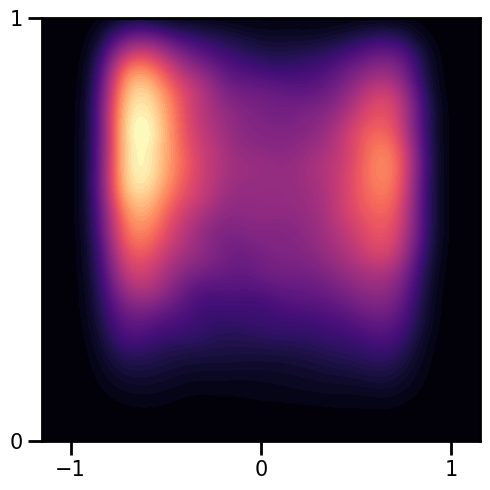

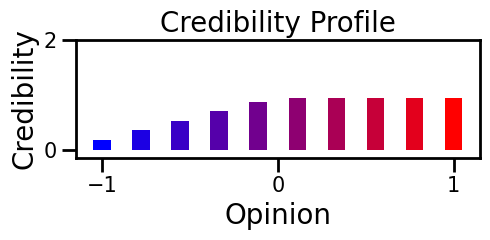

<ipython-input-10-2307f92f164a>:165: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(env.ym.cpu(),avg_credibility,'-o',linewidth=3,marker=".", markersize=50,alpha=1)


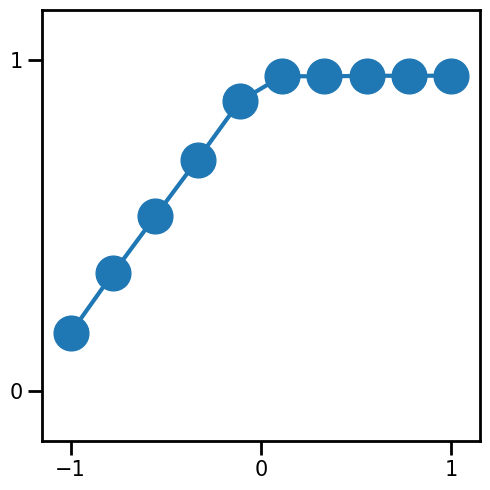

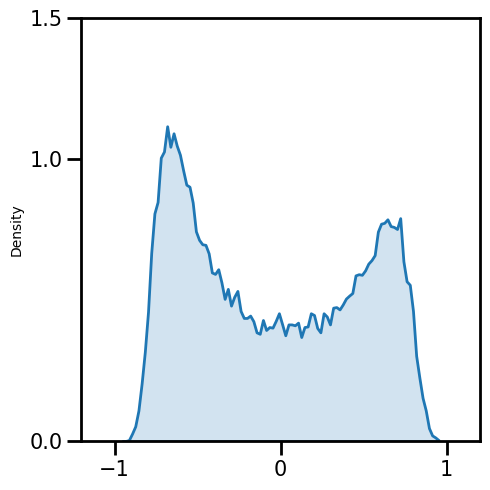

<ipython-input-10-2307f92f164a>:206: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y=env.AEm.sum(axis=2).cpu().flatten()[x>0].mean()/env.terminal_time


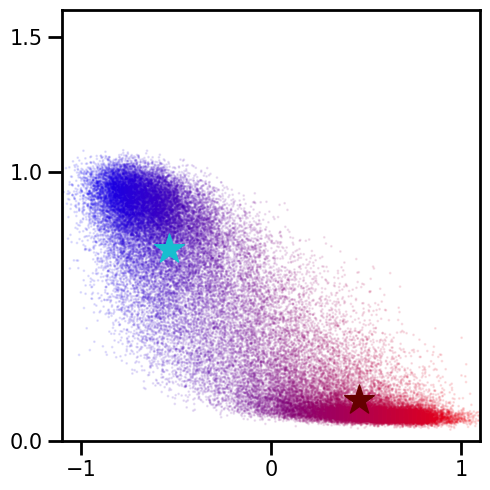

In [ ]:
import os
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import scipy.stats as stats


# ----------------------
# Check Device
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# Hyperparameters
num_envs = 100
N = 500
M = 10
gamma = 0.9
learning_rate = 1e-4
max_train_steps = 30000    # total training updates
train_start = 2000         # minimum replay buffer size before training
train_freq = 10            # train every N environment steps
batch_size = 128
terminal_time =200
capacity = 300 * num_envs * terminal_time
tau = 0.005
epsilon = 0.1
beta = 10              # inverse temperature for softmax action selection
obs_dim = 30 + M         # (nbins=30 + M=10 => 40)
action_dim = 9           # 9 discrete actions
fixed_opponent_action = 0  # The opponent always plays action 0
op_type="good_player"

# Create directories
os.makedirs(op_type, exist_ok=True)

# Create environment
env = OpinionEnv9Actions(
    num_envs=num_envs,
    N=N,
    M=M,
    terminal_time=terminal_time,
    bM=5,
    b=20,
    noise_level=0.1,
    h=0.1,
    nbins=30,
    r_scale=100,
    eta=1,
    eta2=1,
    beta_1=3,
    beta_2=2,
    lambda_c=0.98
)






test_net = QNet(observation_dim=obs_dim, action_dim=action_dim).to(device)
#########################################
#  1) LOAD the final trained model weights
#########################################
model_path = "models_single_agent/final_eval_net.pth"  # or use "checkpoint_epoch_1000.pth" etc.
# model_path = "models_single_agent/checkpoint_net.pth"
test_net.load_state_dict(torch.load(model_path, map_location=device))
test_net.eval()
# print(f"Loaded model from {model_path}")

#########################################
#  2) Run the testing (env.num_env episodes)
#########################################
obs = env.reset()
opinon_data=torch.zeros([env.num_envs,N,env.terminal_time],device=device)
overall_reward=0
with torch.no_grad():
    while True:
        # Choose actions for each env
        a_pl = eval_net.batch_act(obs, epsilon=epsilon, beta=beta)
        # The opponent always plays the fixed action.
        a_op = fixed_opponent_action * torch.ones(env.num_envs, device=device, dtype=torch.long)

        # Step the environment
        next_obs, rewards, done, _ = env.step(a_pl, a_op)
        overall_reward+=rewards.mean().item()
        obs = next_obs.clone()
        mask_done = (done == True)
        if mask_done[0]:
          print("Done")
          break
        opinon_data[:,:,env.t[0].to(torch.int)]=env.x

print(f"Average reward: {overall_reward/env.terminal_time}")

import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("custom_blue_red", [(0, 0, 1), (1, 0, 0)], N=100)
#########################################
#  3) Plotting opinon-susceptibility distributions
#########################################
# Plot final average credibility
avg_credibility =  env.c.detach().cpu().numpy() .mean(axis=0)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.kdeplot(x=opinon_data.detach().mean(axis=2).reshape(-1).cpu().numpy(), y=env.s.detach().reshape(-1).cpu().numpy(), fill=True, thresh=None, cmap="magma", levels=100, ax=ax)
ax.set_xlim(-1.15, 1.15)
ax.set_ylim(0, 1)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
plt.tight_layout()
plt.savefig(f'{op_type}/xs200-b10.svg')
plt.show()
# Create the custom blue-red colormap




# Assume that env.ym and env.c[0] are available from your environment
# Convert tensor data to numpy arrays (or adjust if they are already numpy arrays)
opinions = env.ym.cpu().numpy()            # x-values (Opinion)
credibility = env.c.cpu().numpy().mean(axis=0)         # y-values (Credibility)
norm = plt.Normalize(vmin=-1, vmax=1)
bar_colors = cmap(norm(opinions))

fig, ax = plt.subplots(figsize=(5, 2.5))
bar_width = 0.1

ax.bar(opinions, credibility, width=bar_width, color=bar_colors, align='center')

# Set the limits, ticks, and styling as before
ax.set_xlim([-1.15, 1.15])
ax.set_ylim([-0.15, 1.15])
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 2])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Set titles and labels
ax.set_title("Credibility Profile", fontsize=20)
ax.set_xlabel("Opinion", fontsize=20)
ax.set_ylabel("Credibility", fontsize=20)

# Adjust layout and save/show the figure
plt.tight_layout()
plt.savefig(f"{op_type}/cx_bar.svg", dpi=300)
plt.show()
plt.close()




fig,ax=plt.subplots(figsize=(5,5))
ax.plot(env.ym.cpu(),avg_credibility,'-o',linewidth=3,marker=".", markersize=50,alpha=1)
ax.set_xlim([-1.15 ,1.15])
ax.set_ylim([-0.15, 1.15])
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
plt.tight_layout()
plt.savefig(f'{op_type}/xc_bad_player.svg')
plt.show()

fig,ax=plt.subplots(figsize=(5,5))
sns.histplot(opinon_data.detach().mean(axis=2).reshape(-1).cpu().numpy(),
             bins=100, element="poly", stat="density",alpha=.2,linewidth=2)
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(0, 1.5)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0,1 ,1.5])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
# ax.set_xlabel('Opinion',fontsize=15)
# ax.set_ylabel('Credibility',fontsize=15)
plt.tight_layout()
plt.savefig(f"{op_type}/Dist.svg",dpi=300)
plt.show()



cmap = LinearSegmentedColormap.from_list("custom_blue_red",[(0, 0, 1), (1, 0, 0)], N=100)
fig,ax=plt.subplots(figsize=(5,5))
env_rand=np.random.randint(0,env.num_envs)
x=env.x.squeeze().cpu().numpy().flatten()
ax.scatter(y=env.AEm.sum(axis=2).cpu().flatten().numpy()/(env.terminal_time-1),x=x,c=x,cmap=cmap,s=1,alpha=.1)
ax.scatter(y=env.AEm.sum(axis=2).cpu().flatten()[x>0].mean()/env.terminal_time
           ,x=x[x>0].mean(),s=500,alpha=1,c=[.4,0,0],marker='*',linewidths=1)
ax.scatter(y=env.AEm.sum(axis=2).cpu().flatten()[x<0].mean()/env.terminal_time
           ,x=x[x<0].mean(),s=500,alpha=1,c='tab:cyan',marker='*',linewidths=1)
# ax.scatter(y=env.AEm[env_rand,:,:].sum(axis=1).cpu().flatten().numpy()/(env.terminal_time-1),x=x,c=x,cmap=cmap,s=10,alpha=1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(0, 1.6)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0,1 ,1.5])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
# ax.set_xlabel('Opinion',fontsize=15)
# ax.set_ylabel('Credibility',fontsize=15)
plt.tight_layout()
plt.savefig(f"{op_type}/Exposure.svg",dpi=300)
plt.show()
plt.close()




## Little Bad player

In [ ]:
# ----------------------
# 1) Modified Environment (same as before)
# ----------------------
class OpinionEnv9Actions:
    """
    Environment that uses 9 discrete actions for each "player" (row & column).
    Here, we will treat the 'player' action as the one we learn while the
    'opponent' action will be fixed.
    """
    def __init__(self,
                 num_envs=32,
                 N=500,
                 M=10,
                 terminal_time=200,
                 bM=5,
                 b=20,
                 noise_level=0.1,
                 h=0.1,
                 nbins=30,
                 r_scale=100,
                 eta=1,
                 eta2=2,
                 beta_1=3,
                 beta_2=2,
                 lambda_c=0.98):
        self.num_envs = num_envs
        self.N = N
        self.M = M
        self.terminal_time = terminal_time
        self.bM = bM
        self.b = b
        self.noise_level = noise_level
        self.h = torch.tensor(h, device=device, dtype=torch.float32)
        self.nbins = nbins
        self.r_scale = r_scale
        self.eta = eta
        self.eta2 = eta2
        self.lambda_c = lambda_c
        self.pi = torch.tensor(math.pi, device=device)

        # Beta distribution for s
        BetaDist = torch.distributions.beta.Beta(beta_1, beta_2)

        # Media positions in [-1,1]
        self.ym = torch.linspace(-1, 1, steps=self.M, device=device)

        # Environment states: x, c, t, s
        self.x = torch.zeros(self.num_envs, self.N, device=device)
        self.c = torch.zeros(self.num_envs, self.M, device=device)
        self.t = torch.zeros(self.num_envs, device=device)
        self.s = BetaDist.sample(sample_shape=(self.num_envs, self.N)).to(device)
        self.AEm = torch.zeros((self.num_envs, self.N, self.M), device=device)

        # Exactly 9 actions
        self.action_dim = 9

        # Probabilities and deltas for the 9 discrete actions
        self.probabilities = torch.tensor(
            [0.95, 0.95, 0.95, 0.50, 0.50, 0.10, 0.10, 0.50, 0.10],
            device=device
        )
        self.deltas = torch.tensor(
            [0.000001, 0.85, 0.45, -0.00001, -0.45, -0.85, -0.0000001, 0.4, -0.4],
            device=device
        )
        # For the M/2 dimension: used to create Bernoulli vectors from discrete actions
        self.zm = torch.linspace(0, 1, steps=self.M // 2, device=device)

        self.reset()

    def reset(self):
        with torch.no_grad():
            self.x.uniform_(-1.0, 1.0)
            self.c.fill_(1.0)
            self.t.zero_()
            BetaDist = torch.distributions.beta.Beta(3, 2)
            self.s = BetaDist.sample(sample_shape=(self.num_envs, self.N)).to(device)
            self.AEm.fill_(0.0)
        return self.state2obs()

    def state2obs(self):
        """
        Observation shape: [num_envs, nbins + M] = [hist(x), c].
        """
        obs_list = []
        for i in range(self.num_envs):
            hist_i = torch.histc(self.x[i], bins=self.nbins, min=-1, max=1)
            hist_i = hist_i / self.N
            obs_list.append(torch.cat([hist_i, self.c[i]]))
        obs = torch.stack(obs_list, dim=0)
        return obs

    def _convert_action_ids_to_vec(self, action_ids):
        """
        Convert each action_id in {0..8} to an M/2 Bernoulli vector.
        """
        base_probs = self.probabilities[action_ids]  # [num_envs]
        delta_probs = self.deltas[action_ids]        # [num_envs]
        final_prob = base_probs.unsqueeze(1) - self.zm.unsqueeze(0) * delta_probs.unsqueeze(1)
        final_prob = final_prob.clamp(min=0.0, max=1.0)
        action_vec = torch.bernoulli(final_prob)
        return action_vec  # shape: [num_envs, M//2]

    def step(self, action_pl_ids, action_op_ids):
        """
        Step the environment by one Euler iteration.
        action_pl_ids: player’s discrete actions (shape [num_envs])
        action_op_ids: opponent’s discrete actions (shape [num_envs]) – fixed.
        """
        with torch.no_grad():
            # Build row & column actions
            row_act = self._convert_action_ids_to_vec(action_pl_ids)
            col_act = self._convert_action_ids_to_vec(action_op_ids)
            action = torch.cat([row_act, col_act], dim=1)

            DM = self.ym.view(1, 1, -1) - self.x.unsqueeze(2)  # [num_envs, N, M]
            xx = self.x.unsqueeze(2)
            D = xx - xx.transpose(1, 2)                        # [num_envs, N, N]

            # Media adjacency factor
            fac = (1.0 + self.eta * action).unsqueeze(1) * (
                1.0 + self.eta2 * (2.0 - self.c - action).unsqueeze(1) * (1.0 - self.s).unsqueeze(2)
            )
            AM = torch.exp(-self.bM * fac * torch.abs(DM))     # [num_envs, N, M]
            A = torch.exp(-self.b * torch.abs(D))              # [num_envs, N, N]
            self.media_attention = AM

            self.AEm += torch.exp(-self.bM * torch.abs(DM)) * (1 - action.unsqueeze(1))
            # Credibility update
            self.c = self.c * self.lambda_c + action * (1 - self.lambda_c)

            # Compute social and media updates
            x_update_social = -(A * D).sum(dim=2) / A.sum(dim=2).clamp_min(1e-12)
            x_update_media = (AM * DM).sum(dim=2) / AM.sum(dim=2).clamp_min(1e-12)

            noise = torch.normal(mean=0.0, std=self.noise_level, size=(self.num_envs, self.N), device=device)
            self.x = self.x + self.h * (x_update_social + x_update_media) + torch.sqrt(self.h) * noise

            self.t += 1

            sin_val = torch.sin((self.pi / 2.0) * self.x)
            sin_pow5 = sin_val.pow(5)
            mean_sin_pow5 = sin_pow5.mean(dim=1)
            rewards = self.r_scale * (-mean_sin_pow5)
            done = (self.t >= self.terminal_time)
            if done.any():
              rewards=100*rewards


        next_obs = self.state2obs()
        return next_obs, rewards, done, {}


# ----------------------
# 2) GPU-based Replay Buffer (unchanged except that we now only really need the player's action)
# ----------------------
class GPUReplayBuffer:
    def __init__(self, capacity, obs_dim):
        self.capacity = capacity
        self.obs_dim = obs_dim
        self.index = 0
        self.size = 0

        self.obs_buf      = torch.zeros((capacity, obs_dim), device=device)
        self.next_obs_buf = torch.zeros((capacity, obs_dim), device=device)
        self.actions_pl   = torch.zeros((capacity,), dtype=torch.long, device=device)
        # Although we no longer need the opponent’s action (it is fixed), we store it for compatibility.
        self.actions_op   = torch.zeros((capacity,), dtype=torch.long, device=device)
        self.rewards      = torch.zeros((capacity,), device=device)
        self.dones        = torch.zeros((capacity,), device=device)

    def store(self, obs, action_pl, action_op, reward, next_obs, done):
        batch_size = obs.shape[0]
        end_idx = self.index + batch_size

        if end_idx <= self.capacity:
            idx_range = torch.arange(self.index, end_idx, device=device)
        else:
            remainder = end_idx - self.capacity
            idx_range1 = torch.arange(self.index, self.capacity, device=device)
            idx_range2 = torch.arange(0, remainder, device=device)
            idx_range = torch.cat([idx_range1, idx_range2], dim=0)

        self.obs_buf[idx_range]      = obs
        self.actions_pl[idx_range]   = action_pl
        self.actions_op[idx_range]   = action_op
        self.rewards[idx_range]      = reward
        self.next_obs_buf[idx_range] = next_obs
        self.dones[idx_range]        = done

        self.index = (self.index + batch_size) % self.capacity
        self.size  = min(self.size + batch_size, self.capacity)

    def sample(self, batch_size):
        idxs = np.random.randint(0, self.size, size=batch_size)
        idxs_t = torch.from_numpy(idxs).to(device)

        obs       = self.obs_buf[idxs_t]
        a_pl      = self.actions_pl[idxs_t]
        a_op      = self.actions_op[idxs_t]  # (will be fixed)
        rewards   = self.rewards[idxs_t]
        next_obs  = self.next_obs_buf[idxs_t]
        dones     = self.dones[idxs_t]
        return obs, a_pl, a_op, rewards, next_obs, dones


# ----------------------
# 3) Single-Agent Q–Network
# ----------------------
class QNet(nn.Module):
    """
    A simple Q–network that outputs Q(s,a) for the player's 9 actions.
    """
    def __init__(self, observation_dim, action_dim=9):
        super(QNet, self).__init__()
        self.observation_dim = observation_dim
        self.action_dim = action_dim

        hidden1 = 64
        hidden2 = 64
        hidden3 = 64

        self.fc1 = nn.Linear(self.observation_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.out = nn.Linear(hidden3, self.action_dim)

    def forward(self, obs):
        x = F.relu(self.fc1(obs))
        x = F.relu(self.fc2(x))
        x = (self.fc3(x))
        q = self.out(x)  # Shape: [batch, action_dim]
        return q

    def batch_act(self, obs, epsilon=0.1, beta=10.0):
        """
        Epsilon–greedy action selection.
        With probability epsilon, choose a random action.
        Otherwise, sample from a softmax distribution computed from Q–values.
        """
        with torch.no_grad():
            q_values = self.forward(obs)  # [batch, action_dim]
            # Compute softmax probabilities (using beta as an inverse temperature)
            pi = F.softmax(beta * q_values, dim=-1)
            batch_size = obs.shape[0]
            actions = torch.empty(batch_size, dtype=torch.long, device=device)
            # Epsilon–greedy: decide for each sample whether to choose random action
            rand_vals = torch.rand(batch_size, device=device)
            random_mask = rand_vals < epsilon
            num_random = random_mask.sum().item()
            if num_random > 0:
                actions[random_mask] = torch.randint(0, self.action_dim, (num_random,), device=device)
            # For non–random selections, sample from the softmax distribution
            if (~random_mask).sum().item() > 0:
                dist = torch.distributions.Categorical(pi[~random_mask])
                actions[~random_mask] = dist.sample()
        return actions


# ----------------------
# 4) Soft Q–Update for Single Agent
# ----------------------
def soft_q_update_single(replay_buffer, target_net, eval_net, gamma, optimizer, batch_size, tau=0.01, beta=10.0):
    """
    One gradient update for the single agent.
    """
    obs, a_pl, a_op, rewards, next_obs, dones = replay_buffer.sample(batch_size)
    # Compute current Q(s,a) for the player's action only.
    q_values = eval_net(obs)  # [batch, action_dim]
    q_sa = q_values.gather(1, a_pl.unsqueeze(1)).squeeze(1)

    # Compute V(s') using soft–max (log–sum–exp)
    with torch.no_grad():
        q_values_next = target_net(next_obs)  # [batch, action_dim]
        max_q, _ = q_values_next.max(dim=1, keepdim=True)
        # Correct numerically stable softmax value:
        V_next = max_q.squeeze(1) + (1.0 / beta) * torch.log(torch.sum(torch.exp(beta * (q_values_next - max_q)), dim=1))
        target = rewards + gamma * (1.0 - dones) * V_next

    # with torch.no_grad():
    #     q_values_next = target_net(next_obs)  # [batch, action_dim]
    #     # Numerically stable log–sum–exp:
    #     max_q, _ = q_values_next.max(dim=1, keepdim=True)
    #     V_next = (1.0 / beta) * (torch.log(torch.sum(torch.exp(beta * (q_values_next - max_q)), dim=1)) + max_q.squeeze(1))
    #     target = rewards + gamma * (1.0 - dones) * V_next

    loss = F.mse_loss(q_sa, target)
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(eval_net.parameters(), 1.0)
    optimizer.step()

    # Soft update of target network parameters
    with torch.no_grad():
        for tp, ep in zip(target_net.parameters(), eval_net.parameters()):
            tp.data.copy_(tau * ep.data + (1 - tau) * tp.data)

    return loss.item()


def training_plot(env, rewards_history, step_count, train_count):
    with torch.no_grad():
        avg_rew_recent = np.mean(rewards_history[-100:]) if len(rewards_history) > 100 else np.mean(rewards_history)
        print(f"Step: {step_count}, Train count: {train_count}, AvgReward(last100): {avg_rew_recent:.4f}")

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        axes[0].plot(rewards_history, label="Avg Reward per Step")
        axes[0].set_title(f"Average Reward up to Step {step_count}")
        axes[0].set_xlabel("Env Step")
        axes[0].set_ylabel("Average Reward")
        axes[0].legend()

        avg_credibility = env.c.detach().cpu().numpy().mean(axis=0)
        M = avg_credibility.shape[0]
        axes[1].scatter(np.linspace(-1, 1, M), avg_credibility, s=100, alpha=0.7)
        axes[1].set_xlabel("Media Position")
        axes[1].set_ylabel("Avg Credibility")
        axes[1].set_title("Credibility vs. Media Position")

        plt.tight_layout()
        plt.show()
        plt.close()


# ----------------------
# 5) Main Training Loop for Single Agent
# ----------------------

# Hyperparameters
num_envs = 100
N = 500
M = 10
gamma = 0.9
learning_rate = 1e-4
max_train_steps = 30000    # total training updates
train_start = 2000         # minimum replay buffer size before training
train_freq = 10            # train every N environment steps
batch_size = 128
terminal_time =200
capacity = 300 * num_envs * terminal_time
tau = 0.005
epsilon = 0.1
beta = 10              # inverse temperature for softmax action selection
obs_dim = 30 + M         # (nbins=30 + M=10 => 40)
action_dim = 9           # 9 discrete actions
fixed_opponent_action = 7  # The opponent always plays action 7

# Create directories for saving models/plots
os.makedirs("models_single_agent", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# Create environment
env = OpinionEnv9Actions(
    num_envs=num_envs,
    N=N,
    M=M,
    terminal_time=terminal_time,
    bM=5,
    b=20,
    noise_level=0.1,
    h=0.1,
    nbins=30,
    r_scale=100,
    eta=1,
    eta2=1,
    beta_1=3,
    beta_2=2,
    lambda_c=0.98
)

# Create replay buffer on GPU
buffer = GPUReplayBuffer(capacity, obs_dim=obs_dim)

# Create networks
eval_net = QNet(observation_dim=obs_dim, action_dim=action_dim).to(device)
target_net = QNet(observation_dim=obs_dim, action_dim=action_dim).to(device)
target_net.load_state_dict(eval_net.state_dict())

optimizer = torch.optim.Adam(eval_net.parameters(), lr=learning_rate, weight_decay=1e-4)

# Initial environment reset
obs = env.reset()

step_count = 0    # counts environment steps
train_count = 0   # counts training updates
rewards_history = []
loss_history = []
done_count=0

over_all_rewards=0
while train_count < max_train_steps:
    # The learning agent selects an action (for the 'player')
    a_pl = eval_net.batch_act(obs, epsilon=epsilon, beta=beta)
    # The opponent always plays the fixed action.
    a_op = fixed_opponent_action * torch.ones(env.num_envs, device=device, dtype=torch.long)

    # Step the environment
    next_obs, rewards, done, _ = env.step(a_pl, a_op)
    step_count += 1
    over_all_rewards+=rewards.mean().item()
    # Store transition in the replay buffer
    buffer.store(obs, a_pl, a_op, rewards, next_obs, done.float())

    obs = next_obs.clone()

    # Train only if enough samples have been collected
    if buffer.size > train_start:
        if step_count % train_freq == 0:
            # print("trained")
            train_count += 1
            loss_val = soft_q_update_single(buffer, target_net, eval_net, gamma, optimizer, batch_size, tau, beta)
            loss_history.append(loss_val)

    # Reset environments that are done
    mask_done = (done == True)
    if mask_done.any():
        rewards_history.append(over_all_rewards/env.terminal_time)
        over_all_rewards=0
        # print("Reset")
        done_count+=1
        if train_count > 0:
            # print("plot")
            if done_count%10==0:
                checkpoint_path = "models_single_agent/checkpoint_net.pth"
                torch.save(eval_net.state_dict(), checkpoint_path)
                training_plot(env, rewards_history, step_count, train_count)
                # rewards_history=[]
                print(f"Saved checkpoint: {checkpoint_path}")
        new_obs = env.reset()
        obs[mask_done] = new_obs[mask_done]

# Save final model
final_path = "models_single_agent/final_eval_net.pth"
torch.save(eval_net.state_dict(), final_path)
print(f"Training done. Final model saved at {final_path}")


Output hidden; open in https://colab.research.google.com to view.

Using device: cuda


<ipython-input-3-59ef32863a6f>:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_net.load_state_dict(torch.load(model_path, map_location=device))


Done
Average reward: 0.5876717795385048


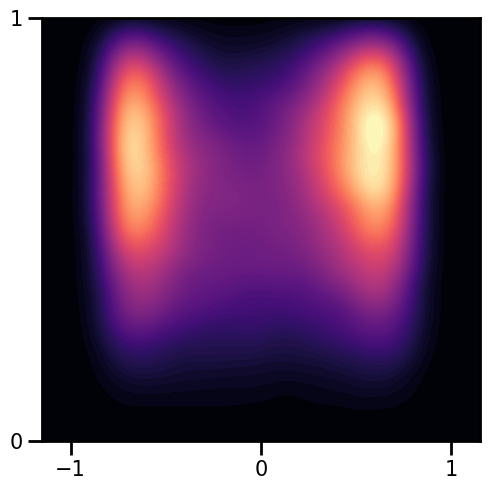

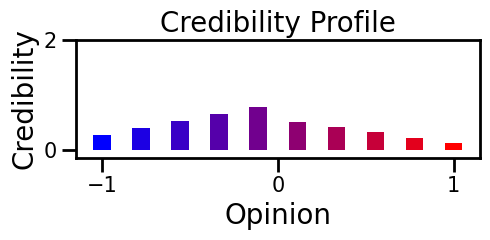

<ipython-input-3-59ef32863a6f>:165: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(env.ym.cpu(),avg_credibility,'-o',linewidth=3,marker=".", markersize=50,alpha=1)


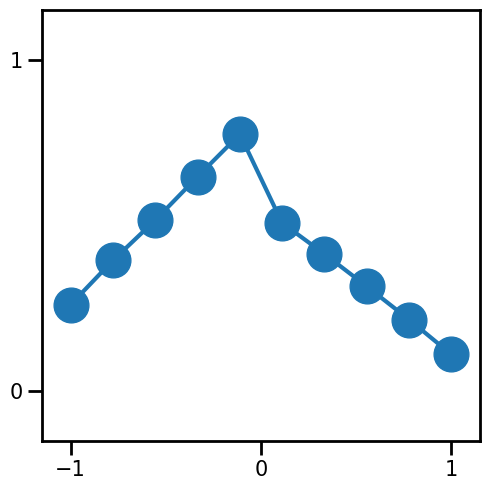

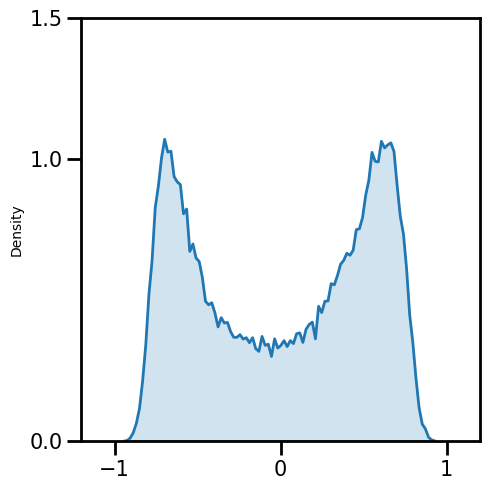

<ipython-input-3-59ef32863a6f>:206: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y=env.AEm.sum(axis=2).cpu().flatten()[x>0].mean()/env.terminal_time


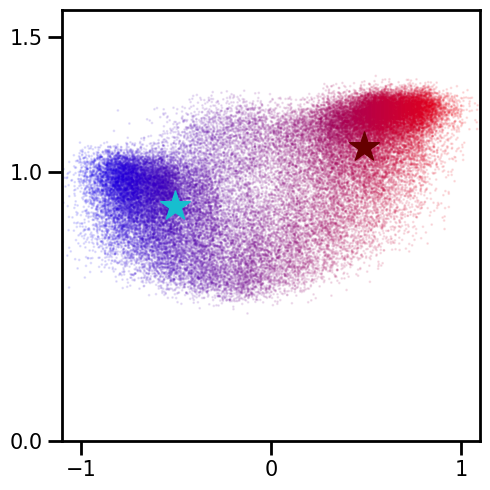

In [ ]:
import os
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import scipy.stats as stats


# ----------------------
# Check Device
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# Hyperparameters
num_envs = 100
N = 500
M = 10
gamma = 0.9
learning_rate = 1e-4
max_train_steps = 30000    # total training updates
train_start = 2000         # minimum replay buffer size before training
train_freq = 10            # train every N environment steps
batch_size = 128
terminal_time =200
capacity = 300 * num_envs * terminal_time
tau = 0.005
epsilon = 0.1
beta = 10              # inverse temperature for softmax action selection
obs_dim = 30 + M         # (nbins=30 + M=10 => 40)
action_dim = 9           # 9 discrete actions
fixed_opponent_action = 7  # The opponent always plays action 0
op_type="little_bad_player"

# Create directories
os.makedirs(op_type, exist_ok=True)

# Create environment
env = OpinionEnv9Actions(
    num_envs=num_envs,
    N=N,
    M=M,
    terminal_time=terminal_time,
    bM=5,
    b=20,
    noise_level=0.1,
    h=0.1,
    nbins=30,
    r_scale=100,
    eta=1,
    eta2=1,
    beta_1=3,
    beta_2=2,
    lambda_c=0.98
)






test_net = QNet(observation_dim=obs_dim, action_dim=action_dim).to(device)
#########################################
#  1) LOAD the final trained model weights
#########################################
model_path = "models_single_agent/final_eval_net.pth"  # or use "checkpoint_epoch_1000.pth" etc.
# model_path = "models_single_agent/checkpoint_net.pth"
test_net.load_state_dict(torch.load(model_path, map_location=device))
test_net.eval()
# print(f"Loaded model from {model_path}")

#########################################
#  2) Run the testing (env.num_env episodes)
#########################################
obs = env.reset()
opinon_data=torch.zeros([env.num_envs,N,env.terminal_time],device=device)
overall_reward=0
with torch.no_grad():
    while True:
        # Choose actions for each env
        a_pl = eval_net.batch_act(obs, epsilon=epsilon, beta=beta)
        # The opponent always plays the fixed action.
        a_op = fixed_opponent_action * torch.ones(env.num_envs, device=device, dtype=torch.long)

        # Step the environment
        next_obs, rewards, done, _ = env.step(a_pl, a_op)
        overall_reward+=rewards.mean().item()
        obs = next_obs.clone()
        mask_done = (done == True)
        if mask_done[0]:
          print("Done")
          break
        opinon_data[:,:,env.t[0].to(torch.int)]=env.x

print(f"Average reward: {overall_reward/env.terminal_time}")

import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("custom_blue_red", [(0, 0, 1), (1, 0, 0)], N=100)
#########################################
#  3) Plotting opinon-susceptibility distributions
#########################################
# Plot final average credibility
avg_credibility =  env.c.detach().cpu().numpy() .mean(axis=0)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.kdeplot(x=opinon_data.detach().mean(axis=2).reshape(-1).cpu().numpy(), y=env.s.detach().reshape(-1).cpu().numpy(), fill=True, thresh=None, cmap="magma", levels=100, ax=ax)
ax.set_xlim(-1.15, 1.15)
ax.set_ylim(0, 1)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
plt.tight_layout()
plt.savefig(f'{op_type}/xs200-b10.svg')
plt.show()
# Create the custom blue-red colormap




# Assume that env.ym and env.c[0] are available from your environment
# Convert tensor data to numpy arrays (or adjust if they are already numpy arrays)
opinions = env.ym.cpu().numpy()            # x-values (Opinion)
credibility = env.c.cpu().numpy().mean(axis=0)         # y-values (Credibility)
norm = plt.Normalize(vmin=-1, vmax=1)
bar_colors = cmap(norm(opinions))

fig, ax = plt.subplots(figsize=(5, 2.5))
bar_width = 0.1

ax.bar(opinions, credibility, width=bar_width, color=bar_colors, align='center')

# Set the limits, ticks, and styling as before
ax.set_xlim([-1.15, 1.15])
ax.set_ylim([-0.15, 1.15])
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 2])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Set titles and labels
ax.set_title("Credibility Profile", fontsize=20)
ax.set_xlabel("Opinion", fontsize=20)
ax.set_ylabel("Credibility", fontsize=20)

# Adjust layout and save/show the figure
plt.tight_layout()
plt.savefig(f"{op_type}/cx_bar.svg", dpi=300)
plt.show()
plt.close()




fig,ax=plt.subplots(figsize=(5,5))
ax.plot(env.ym.cpu(),avg_credibility,'-o',linewidth=3,marker=".", markersize=50,alpha=1)
ax.set_xlim([-1.15 ,1.15])
ax.set_ylim([-0.15, 1.15])
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
plt.tight_layout()
plt.savefig(f'{op_type}/xc_bad_player.svg')
plt.show()

fig,ax=plt.subplots(figsize=(5,5))
sns.histplot(opinon_data.detach().mean(axis=2).reshape(-1).cpu().numpy(),
             bins=100, element="poly", stat="density",alpha=.2,linewidth=2)
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(0, 1.5)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0,1 ,1.5])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
# ax.set_xlabel('Opinion',fontsize=15)
# ax.set_ylabel('Credibility',fontsize=15)
plt.tight_layout()
plt.savefig(f"{op_type}/Dist.svg",dpi=300)
plt.show()



cmap = LinearSegmentedColormap.from_list("custom_blue_red",[(0, 0, 1), (1, 0, 0)], N=100)
fig,ax=plt.subplots(figsize=(5,5))
env_rand=np.random.randint(0,env.num_envs)
x=env.x.squeeze().cpu().numpy().flatten()
ax.scatter(y=env.AEm.sum(axis=2).cpu().flatten().numpy()/(env.terminal_time-1),x=x,c=x,cmap=cmap,s=1,alpha=.1)
ax.scatter(y=env.AEm.sum(axis=2).cpu().flatten()[x>0].mean()/env.terminal_time
           ,x=x[x>0].mean(),s=500,alpha=1,c=[.4,0,0],marker='*',linewidths=1)
ax.scatter(y=env.AEm.sum(axis=2).cpu().flatten()[x<0].mean()/env.terminal_time
           ,x=x[x<0].mean(),s=500,alpha=1,c='tab:cyan',marker='*',linewidths=1)
# ax.scatter(y=env.AEm[env_rand,:,:].sum(axis=1).cpu().flatten().numpy()/(env.terminal_time-1),x=x,c=x,cmap=cmap,s=10,alpha=1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(0, 1.6)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0,1 ,1.5])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
# ax.set_xlabel('Opinion',fontsize=15)
# ax.set_ylabel('Credibility',fontsize=15)
plt.tight_layout()
plt.savefig(f"{op_type}/Exposure.svg",dpi=300)
plt.show()
plt.close()


